In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import linear_model
from sklearn import tree
from sklearn import neighbors
from sklearn import ensemble
from sklearn import svm
from sklearn import gaussian_process
from sklearn import naive_bayes
from sklearn import neural_network
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import seaborn as sns
sns.set()
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')

## 데이터 필드
id  - 생물의 ID

bone_length - 생물체의 뼈의 평균 길이. 0에서 1 사이의 정규화 된 값.

rotting_flesh  - 생물의 썩은 살의 비율

hair_length - 평균 머리 길이, 0에서 1 사이의 정규화

has_soul  - 생물체 내의 영혼의 비율

color - 지배적 인 색 : '흰색', '검은 색', '맑은', '푸른 색', '녹색', '피'

type  - 대상 변수 : 'Ghost', 'Goblin', 'Ghoul'

In [26]:
train.head()

,id,bone_length,rotting_flesh,hair_length,has_soul,color,type
0,0,0.354512,0.350839,0.465761,0.781142,clear,Ghoul
1,1,0.575560,0.425868,0.531401,0.439899,green,Goblin
2,2,0.467875,0.354330,0.811616,0.791225,black,Ghoul
3,4,0.776652,0.508723,0.636766,0.884464,black,Ghoul
4,5,0.566117,0.875862,0.418594,0.636438,green,Ghost


In [27]:
test.head()

,id,bone_length,rotting_flesh,hair_length,has_soul,color
0,3,0.471774,0.387937,0.706087,0.698537,black
1,6,0.427332,0.645024,0.565558,0.451462,white
2,9,0.549602,0.491931,0.660387,0.449809,black
3,10,0.638095,0.682867,0.471409,0.356924,white
4,13,0.361762,0.583997,0.377256,0.276364,black


In [28]:
train.shape

(371, 7)

In [29]:
test.shape

(529, 6)

In [30]:
print(np.sort(train['color'].unique()))

['black' 'blood' 'blue' 'clear' 'green' 'white']


In [31]:
def chart(feature):
    ghoul = train[train['type']=='Ghoul'][feature].value_counts()
    goblin = train[train['type']=='Goblin'][feature].value_counts()
    ghost = train[train['type']=='Ghost'][feature].value_counts()
    df = pd.DataFrame([ghoul,goblin,ghost])
    df.index = ['Ghoul','Goblin','Ghost']
    df.plot(kind='bar',stacked=True, figsize=(10,5))

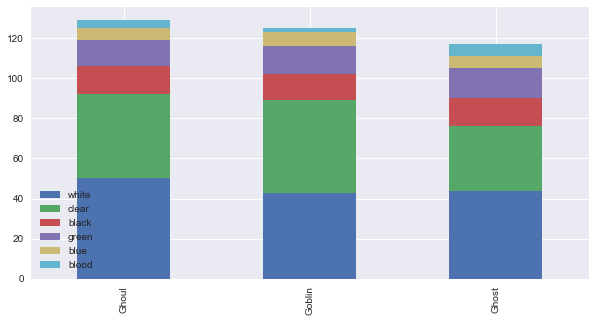

In [32]:
chart('color')

In [33]:
train = train.drop(['color'],axis=1)
test = test.drop(['color'],axis=1)

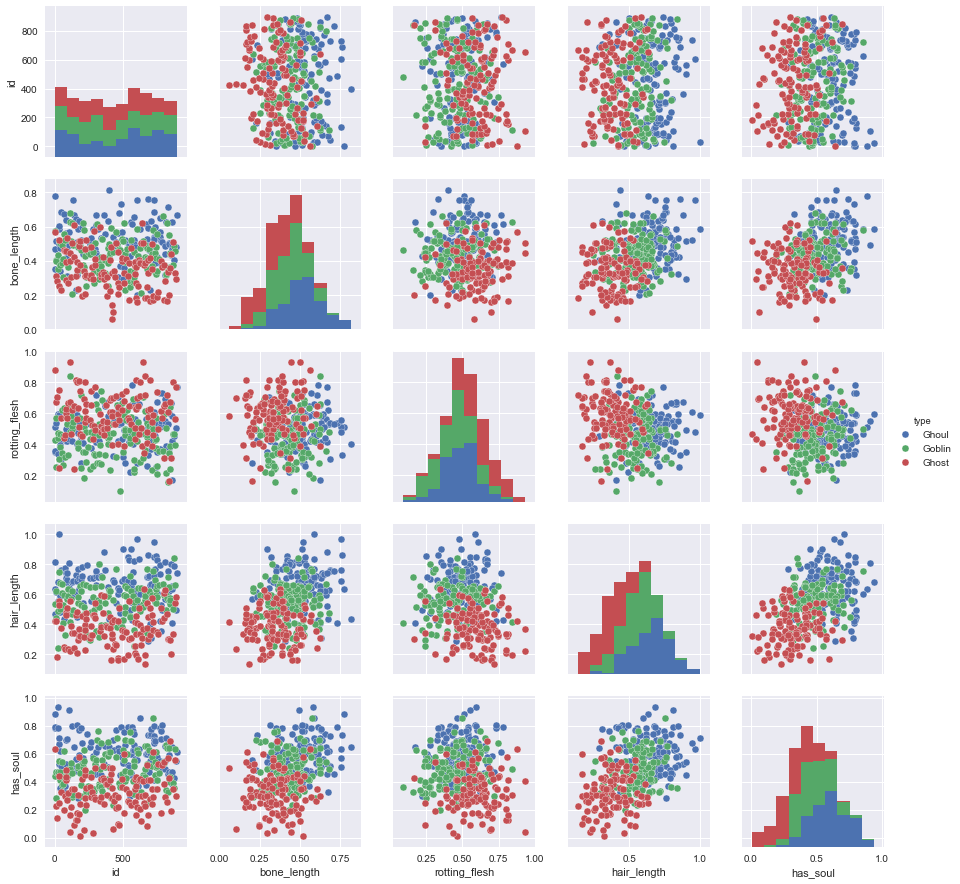

In [34]:
sns.pairplot(train,hue="type")

In [35]:
train['br'] = train.apply(lambda row: row['bone_length']*row['rotting_flesh'],axis=1)
train['bh'] = train.apply(lambda row: row['bone_length']*row['hair_length'],axis=1)
train['bs'] = train.apply(lambda row: row['bone_length']*row['has_soul'],axis=1)
train['rh'] = train.apply(lambda row: row['rotting_flesh']*row['hair_length'],axis=1)
train['rs'] = train.apply(lambda row: row['rotting_flesh']*row['has_soul'],axis=1)
train['hs'] = train.apply(lambda row: row['hair_length']*row['has_soul'],axis=1)

test['br'] = test.apply(lambda row: row['bone_length']*row['rotting_flesh'],axis=1)
test['bh'] = test.apply(lambda row: row['bone_length']*row['hair_length'],axis=1)
test['bs'] = test.apply(lambda row: row['bone_length']*row['has_soul'],axis=1)
test['rh'] = test.apply(lambda row: row['rotting_flesh']*row['hair_length'],axis=1)
test['rs'] = test.apply(lambda row: row['rotting_flesh']*row['has_soul'],axis=1)
test['hs'] = test.apply(lambda row: row['hair_length']*row['has_soul'],axis=1)

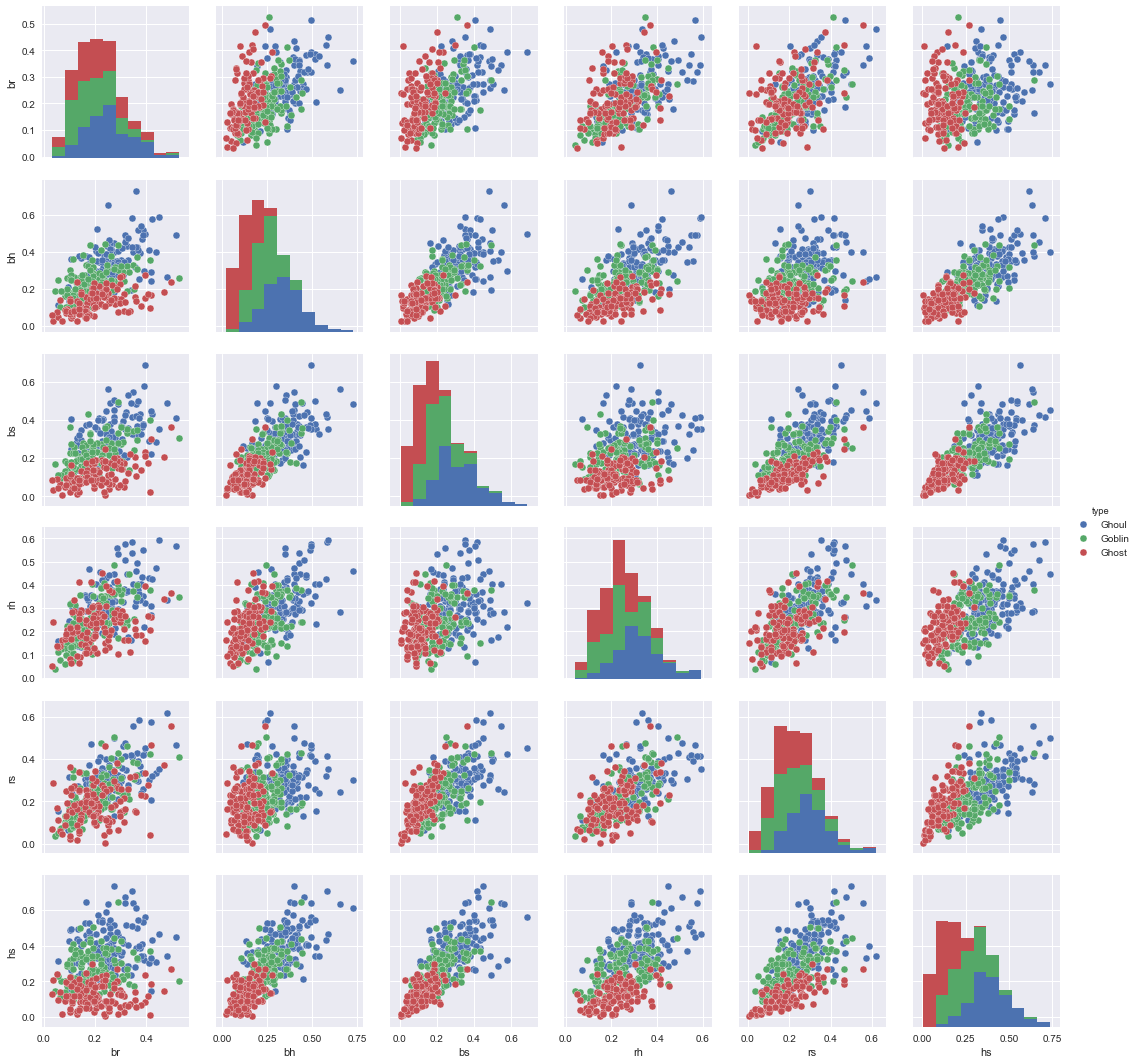

In [36]:
sns.set()
sns.pairplot(train[["br","bh","bs","rh","rs","hs","type"]], hue="type")

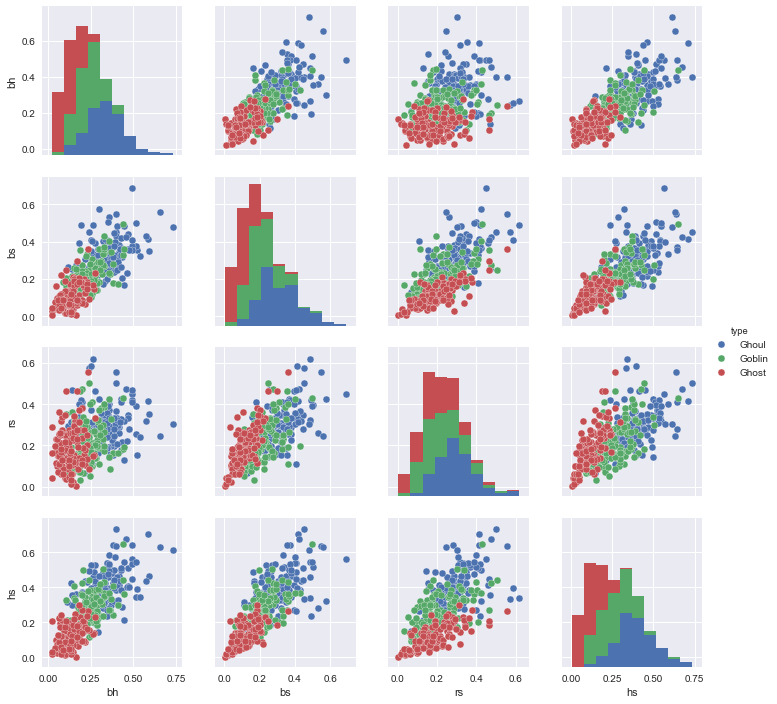

In [37]:
sns.set()
sns.pairplot(train[["bh","bs","rs","hs","type"]], hue="type")

In [50]:
train['bhbs'] = train.apply(lambda row: row['bh']*row['bs'],axis=1)
train['bhrs'] = train.apply(lambda row: row['bh']*row['rs'],axis=1)
train['bhhs'] = train.apply(lambda row: row['bh']*row['hs'],axis=1)
train['bsrs'] = train.apply(lambda row: row['bs']*row['rs'],axis=1)
train['bshs'] = train.apply(lambda row: row['bs']*row['hs'],axis=1)
train['rshs'] = train.apply(lambda row: row['rs']*row['hs'],axis=1)

test['bhbs'] = test.apply(lambda row: row['bh']*row['bs'],axis=1)
test['bhrs'] = test.apply(lambda row: row['bh']*row['rs'],axis=1)
test['bhhs'] = test.apply(lambda row: row['bh']*row['hs'],axis=1)
test['bsrs'] = test.apply(lambda row: row['bs']*row['rs'],axis=1)
test['bshs'] = test.apply(lambda row: row['bs']*row['hs'],axis=1)
test['rshs'] = test.apply(lambda row: row['rs']*row['hs'],axis=1)

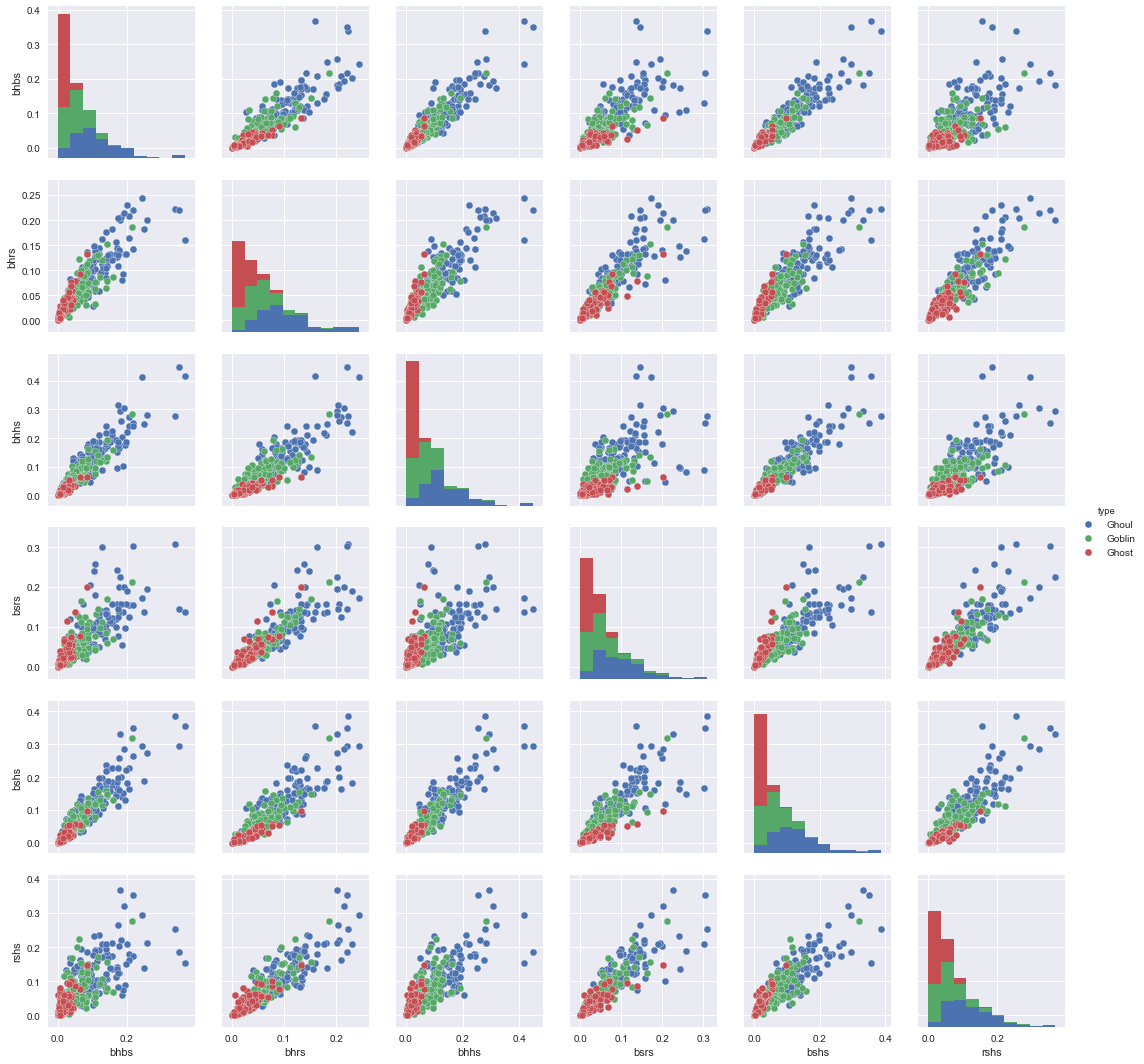

In [51]:
sns.set()
sns.pairplot(train[["bhbs","bhrs","bhhs","bsrs","bshs","rshs","type"]], hue="type")

In [67]:
x_original = train[["bone_length", "rotting_flesh", "hair_length", "has_soul"]]
x_hair_soul = train[["br","bh","bs","rh","rs","hs"]]
y = train[["type"]]

x_test_original = test[["bone_length", "rotting_flesh", "hair_length", "has_soul"]]
x_test_hair_soul = test[["br","bh","bs","rh","rs","hs"]]

In [68]:
clfs = {}
clfs['tr'] = {'clf': tree.DecisionTreeClassifier(), 'name':'DecisionTree'}
clfs['nusvc'] = {'clf': svm.NuSVC(), 'name': 'NuSVC'}
clfs['linearsvc'] = {'clf': svm.LinearSVC(), 'name': 'LinearSVC'}
clfs['SGD'] = {'clf': linear_model.SGDClassifier(), 'name': 'SGDClassifier'}
clfs['GPC'] = {'clf': gaussian_process.GaussianProcessClassifier(), 'name': 'GaussianProcess'}
clfs['nb'] = {'clf': naive_bayes.GaussianNB(), 'name':'GaussianNaiveBayes'}
clfs['bag'] = {'clf': ensemble.BaggingClassifier(neighbors.KNeighborsClassifier(), max_samples=0.5, max_features=0.5), 'name': "BaggingClassifier"}
clfs['gbc'] = {'clf': ensemble.GradientBoostingClassifier(), 'name': 'GradientBoostingClassifier'}

In [69]:
parameters = {'solver': ['lbfgs'], 'max_iter': [1500], 'alpha': 10.0 ** -np.arange(1, 7), 'hidden_layer_sizes':np.arange(5, 12)}
clfs['mlpgrid'] = {'clf': GridSearchCV(neural_network.MLPClassifier(), parameters), 'name': 'MLP with GridSearch'}

parameters = {'kernel':['linear', 'sigmoid', 'poly', 'rbf'], 'gamma':np.linspace(0.0,2.0,num=21),'C': np.linspace(0.5,1.5,num=11)}
clfs['svcgrid'] = {'clf': GridSearchCV(svm.SVC(), parameters), 'name': 'SVC with GridSearch'}

parameters = {'n_estimators':np.arange(64, 1024, step=64)}
clfs['rfgrid'] = {'clf': GridSearchCV(ensemble.RandomForestClassifier(), parameters), 'name': 'Random Forest with GridSearch'}

parameters = {'n_neighbors':np.arange(3, 12)}
clfs['knngrid'] = {'clf': GridSearchCV(neighbors.KNeighborsClassifier(), parameters), 'name': 'KNN with GridSearch'}

parameters = {'n_estimators':np.arange(3, 12)}
clfs['adagrid'] = {'clf': GridSearchCV(ensemble.AdaBoostClassifier(), parameters), 'name': 'AdaBoost with GridSearch'}

parameters = {'C':[1],'tol':[0.0001],'solver': ['newton-cg'], 'multi_class': ['multinomial']}
clfs['lrgrid'] = {'clf': GridSearchCV(linear_model.LogisticRegression(), parameters), 'name': 'LogisticRegression with GridSearch'}

In [70]:
clfs['vote_hair_soul'] = {'clf': ensemble.VotingClassifier(estimators=[
            ('svcgrid', clfs['svcgrid']['clf']),
            ('lrgrid', clfs['lrgrid']['clf']),
            ('gbc', clfs['gbc']['clf'])
        ], voting='hard'), 'name': 'VotingClassifierHairSoul'}

clfs['vote'] = {'clf': ensemble.VotingClassifier(estimators=[
            ('svcgrid', clfs['svcgrid']['clf']),
            ('lrgrid', clfs['lrgrid']['clf']),
            ('nb', clfs['gbc']['clf'])
        ], voting='hard'), 'name': 'VotingClassifier'}

In [71]:
clfs['vote_hair_soul']['clf'] = clfs['vote_hair_soul']['clf'].fit(x_hair_soul, y.values.ravel())
clfs['vote']['clf'] = clfs['vote']['clf'].fit(x_original, y.values.ravel())

In [72]:
clfs['vote_hair_soul']['predictions'] = clfs['vote_hair_soul']['clf'].predict(x_test_hair_soul)
clfs['vote']['predictions'] = clfs['vote']['clf'].predict(x_test_original)

C:\Users\chosun\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\chosun\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [73]:
sub = pd.DataFrame(clfs['vote_hair_soul']['predictions'])
pd.concat([test["id"],sub], axis=1).rename(columns = {0: 'type'}).to_csv("testset_predict4.csv", index=False)

sub = pd.DataFrame(clfs['vote']['predictions'])
pd.concat([test["id"],sub], axis=1).rename(columns = {0: 'type'}).to_csv("testset.csv", index=False)